In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optuna
import pandas as pd

/home/james/Repo/PhD Repo/time_series_clustering/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from time_series.time_series_models import KernelRidgeRegression, RascuttiModel
from time_series.data_generators import LorenzGenerator
from time_series.kernels import GaussianKernel
from time_series.evaluators import MeanSquaredError

2025-10-10 09:18:12.816 | INFO     | time_series.config:<module>:13 - PROJ_ROOT path is: /home/james/Repo/PhD Repo/time_series_clustering


In [3]:
class TimeSeriesData:
    def __init__(self, X, y=None, train_val_test_split=None, dataset_name=None, parameters=None, **kwargs):
        self.__dict__.update(kwargs)
        self.X = X
        self.y = y

        self.N = len(X)
        self.indices = np.arange(self.N)
        self.tvt_split = train_val_test_split
        self.dataset_name = dataset_name if dataset_name else ""
        self.parameters = parameters if parameters else {}

    def train_data(self):
        min_idx = 0
        max_idx = int(self.tvt_split[0]*self.N)
        self.train_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.train_idx], None

        return self.X[self.train_idx], self.y[self.train_idx]

    def val_data(self, lag=0):
        min_idx = int(self.tvt_split[0]*self.N) - lag
        max_idx = int((self.tvt_split[0] + self.tvt_split[1])*self.N)
        self.val_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.val_idx], None

        return self.X[self.val_idx], self.y[self.val_idx]

    def test_data(self, lag=0):
        min_idx = int((self.tvt_split[0] + self.tvt_split[1])*self.N) - lag
        max_idx = self.N 
        self.test_idx = self.indices[min_idx:max_idx]

        if type(self.y) == type(None):
            return self.X[self.test_idx], None

        return self.X[self.test_idx], self.y[self.test_idx]
    
    def drop_data(self):
        self.X = None
        self.y = None

In [4]:
noise_cov = 0
dt = 1e-2
T = 5

dynamics = [
    dict(rho=14, sigma=10, beta=8/3),
    dict(rho=28, sigma=10, beta=8/3),
    dict(rho=28, sigma=1, beta=8/3)
]

starting_points = [
    [1, 1, 1],
    [1, 2, 1],
    [1, 1, 2],
    [2, 1, 1]
]

full_dataset = []
labels = []
for di, d in enumerate(dynamics):
    for s in starting_points:
        _, data = LorenzGenerator(noise_mean=[0,0,0], noise_covariance=noise_cov, dt=dt, T=T, x0=s, **d)()
        full_dataset.append(data)
        labels += [f"X_{di}", f"Y_{di}", f"Z_{di}"]

full_dataset = np.hstack(full_dataset)
dataset = TimeSeriesData(
    X = full_dataset[:-1],
    y = full_dataset[1:],
    train_val_test_split=[0.5, 0.3, 0.2],
    dataset_name="Full Data",
    labels = labels
)

In [5]:
X_train, y_train = dataset.train_data()
X_test, y_test = dataset.test_data()
X_val, y_val = dataset.val_data()

evaluator = MeanSquaredError()

In [6]:
def objective(trial):
    kernels = [
        GaussianKernel(bandwidth=trial.suggest_float(f"bandwidth_{i}", 1, 100))
        for i in range(dataset.X.shape[1])
    ]

    krr_model = KernelRidgeRegression(
        kernels=kernels,
        reg = trial.suggest_float("reg", 1e-10, 1e-2)
    )

    krr_model.fit(X_train, y_train)
    y_pred = krr_model.predict(X_val)

    return evaluator(y_val, y_pred)

study = optuna.create_study()
study.optimize(
    objective,
    n_trials=30,
    timeout=20*60
)

best_params = study.best_params

[I 2025-09-23 10:38:07,015] A new study created in memory with name: no-name-e1e1cbef-97f8-4167-87ed-b6097e1974a4
[I 2025-09-23 10:38:34,563] Trial 0 finished with value: 43.18201981209909 and parameters: {'bandwidth_0': 90.42389521170759, 'bandwidth_1': 72.10020285035986, 'bandwidth_2': 26.52716752653297, 'bandwidth_3': 34.44355044287626, 'bandwidth_4': 32.400547068697676, 'bandwidth_5': 98.90430582411871, 'bandwidth_6': 82.49671257892791, 'bandwidth_7': 86.88288340973166, 'bandwidth_8': 23.66158350464919, 'bandwidth_9': 25.654860308831662, 'bandwidth_10': 18.091490954125714, 'bandwidth_11': 73.36628513733403, 'bandwidth_12': 64.199257423398, 'bandwidth_13': 4.407028048698229, 'bandwidth_14': 32.73085286979081, 'bandwidth_15': 17.2265778856264, 'bandwidth_16': 29.529371778775023, 'bandwidth_17': 78.64428531407574, 'bandwidth_18': 73.72693298174896, 'bandwidth_19': 83.09060968614354, 'bandwidth_20': 44.112257451809306, 'bandwidth_21': 10.23471451065537, 'bandwidth_22': 69.7621183646684

In [15]:
best_params

{'bandwidth_0': 31.44756185506985,
 'bandwidth_1': 13.15836647498686,
 'bandwidth_2': 21.13164099508771,
 'bandwidth_3': 67.62482048358108,
 'bandwidth_4': 42.82432885204581,
 'bandwidth_5': 61.81665167484738,
 'bandwidth_6': 89.45851988197988,
 'bandwidth_7': 72.33144705803949,
 'bandwidth_8': 76.20451277975792,
 'bandwidth_9': 62.00575430280817,
 'bandwidth_10': 14.839552870474387,
 'bandwidth_11': 28.931858594080154,
 'bandwidth_12': 40.286396219897135,
 'bandwidth_13': 45.53847204140293,
 'bandwidth_14': 67.46935755246434,
 'bandwidth_15': 7.894654423405183,
 'bandwidth_16': 82.45285467447468,
 'bandwidth_17': 86.09097916591483,
 'bandwidth_18': 87.06599126229807,
 'bandwidth_19': 16.655078537213637,
 'bandwidth_20': 68.36848702357791,
 'bandwidth_21': 40.398431943234606,
 'bandwidth_22': 40.38790541358343,
 'bandwidth_23': 51.75834735884997,
 'bandwidth_24': 82.11060284413838,
 'bandwidth_25': 13.135808573572763,
 'bandwidth_26': 36.500572600782206,
 'bandwidth_27': 88.49949707104

In [16]:
params = pd.Series(best_params)

<Axes: >

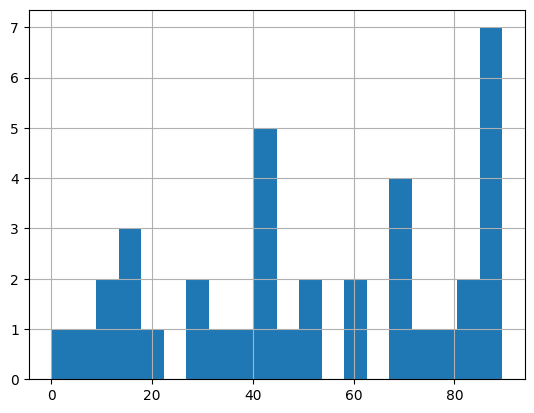

In [17]:
params.hist(bins=20)

In [ ]:
# Kernel Ridge Regression
kernels=[
        GaussianKernel(best_params[f"bandwidth_{i}"]) for i in range(dataset.X.shape[1])
    ]

krr_model = KernelRidgeRegression(
    kernels=kernels,
    reg = best_params["reg"]
)

In [19]:
X_train_all = np.concatenate([X_train, X_test], axis=0)
y_train_all = np.concatenate([y_train, y_test], axis=0)

In [20]:
krr_model.fit(X_train_all, y_train_all)

In [21]:
y_pred = krr_model.predict(X_test)

evaluator(y_pred, y_test)

np.float64(0.12173143763298956)

In [40]:
alphas = krr_model.alpha.reshape(X_train_all.shape[1], -1).T

# Apples to Oranges

In [41]:
X_windowed, y_windowed = krr_model.reshape_data(X_train_all, y_train_all)

In [42]:
k = kernels[0]

In [51]:
alphas.shape

(350, 36)

In [49]:
distance_matrix = np.zeros((X_train_all.shape[1], X_train_all.shape[1]))

In [ ]:
alphas.T

array([[ 1.95154476e-01,  1.91620489e-02, -9.86839339e-02, ...,
         5.73041427e-01,  7.46126827e-01,  9.17794781e-01],
       [-2.14146645e-01, -1.19694508e-01, -3.67861475e-02, ...,
        -7.84285860e-02, -1.85816326e-02,  7.09138982e-02],
       [ 4.50541082e-01,  3.25626390e-01,  2.16611330e-01, ...,
         8.80739870e-01,  1.31829319e+00,  1.86151441e+00],
       ...,
       [-3.54716591e-01, -4.95532707e-01, -6.06167041e-01, ...,
         5.92582006e-02,  3.34011118e-03, -3.56309383e-02],
       [-6.57664213e+00, -5.10254144e+00, -3.70898668e+00, ...,
         6.97631496e-01,  8.16830151e-01,  9.68270813e-01],
       [-6.95220455e-01, -1.13124746e+00, -1.50941772e+00, ...,
         9.90604682e-01,  1.42957929e+00,  1.88803721e+00]],
      shape=(36, 350))

In [44]:
k(X_windowed, X_windowed)

array([[1.        , 0.99944652, 0.99784175, ..., 0.02581868, 0.02697696,
        0.02801871],
       [0.99944652, 1.        , 0.99947109, ..., 0.02612108, 0.02730421,
        0.02836827],
       [0.99784175, 0.99947109, 1.        , ..., 0.02643307, 0.02764264,
        0.02873061],
       ...,
       [0.02581868, 0.02612108, 0.02643307, ..., 1.        , 0.99766927,
        0.991188  ],
       [0.02697696, 0.02730421, 0.02764264, ..., 0.99766927, 1.        ,
        0.99789659],
       [0.02801871, 0.02836827, 0.02873061, ..., 0.991188  , 0.99789659,
        1.        ]], shape=(350, 350))